# 과제3. 직원 이직 분석

* 여러분은 OO회사의 **데이터분석가** 입니다.
* **인사팀**에서는 여러분에게 우리 회사 직원의 **이직(Attrition)에 영향을 주는 요인**을 분석해달라고 요청해 왔습니다.

![](https://adoptostaging.blob.core.windows.net/media/employee-attrition-reasons-9LIqMv.jpg)

## 0.환경설정

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm

import matplotlib
matplotlib.font_manager._rebuild()
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

### 2) 데이터 로딩

In [25]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition_NA.CSV"
data = pd.read_csv(path)
data.drop(['EducationField', 'Education','JobInvolvement', 'StockOptionLevel', 'BusinessTravel','YearsWithCurrManager'
,'YearsInCurrentRole','JobRole', 'Department','EmployeeNumber','EnvironmentSatisfaction','TrainingTimesLastYear','YearsAtCompany']
          , axis = 1, inplace = True)
data['Attrition'] = np.where(data['Attrition']=='Yes', 1, 0)
data.head(10)

,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance
0,0,33,7.0,Male,3,Married,11691,0.0,No,11,4,14,4
1,0,35,18.0,Male,4,Single,9362,2.0,No,11,3,10,3
2,0,42,6.0,Male,1,Married,13348,9.0,No,13,2,18,4
3,0,46,2.0,Female,1,Married,17048,8.0,No,23,1,28,3
4,0,39,NaN,Male,4,Divorced,4127,2.0,No,18,4,7,3
5,1,22,4.0,Male,3,Single,3894,5.0,No,16,3,4,3
6,0,24,21.0,Male,1,Divorced,2296,0.0,No,14,2,2,3
7,0,34,8.0,Male,3,Married,4404,2.0,No,12,1,6,4
8,0,30,20.0,Male,1,Married,9957,0.0,No,15,3,7,2
9,0,26,6.0,Female,4,Married,2659,1.0,Yes,13,3,3,3


|	구분	|	변수 명	|	내용	|	type	|	비고	|
|	----	|	----	|	----	|	----	|	----	|
|	**Target**	|	**Attrition**	|	이직여부, Yes , No	|	범주	| 1- 이직, 0- 잔류		|
|	feature	|	Age	|	나이	|	숫자	|		|
|	feature	|	DistanceFromHome	|	집-직장 거리	|	숫자	|	마일	|
|	feature	|	Gender	|	성별	|	범주	| Male, Female		|
|	feature	|	JobSatisfaction	|	직무 만족도	|	범주	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	feature	|	MaritalStatus	|	결혼상태	|	범주	| Single, Married, Divorced		|
|	feature	|	MonthlyIncome	|	월급	|	숫자	| 달러	|
|	feature	|	NumCompaniesWorked	|	입사 전 근무한 회사 수	|	숫자	|	0 - 우리회사가 첫 직장	|
|	feature	|	RelationshipSatisfaction	|	동료와의 관계	|	범주	| 1 Low, 2 Medium, 3 High, 4 Very High		|
|	feature	|	OverTime	|	야근여부	|	범주	|	Yes, No	|
|	feature	|	PercentSalaryHike	|	전년대비 급여인상율	|	숫자	|	%	|
|	feature	|	TotalWorkingYears	|	총 경력 연수	|	숫자	|		|
|	feature	|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	범주	|	1 Bad, 2 Good, 3 Better, 4 Best	|

* 분석 단위 : 직원 한사람, 한사람...
* 설명에서 언급되어지지 않은 사항은 직접 고민하며 스스로 정해서 진행하시면 됩니다.^^
* 자\~! 이제 시작해 봅시다\~!

----

## 1.가설수립

* 여기서는 가설을 간략히 수립합니다.
    * 숫자형, 범주형 각각 최소 3개 이상씩, 전체 6개 이상의 변수를 도출, 가설을 수립하시오.

* 가설1
>* 귀무가설 : 나이에 따라 이직여부에는 유의미한 차이가 없다.
>* 대립가설 : 나이에 따라 이직여부에는 유의미한 차이가 있다.

* 가설2
>* 귀무가설 : 집-직장 거리에 따라 이직여부에는 유의미한 차이가 없다.
>* 대립가설 : 집-직장 거리에 따라 이직여부에는 유의미한 차이가 있다.

* 가설3
>* 귀무가설 : 성별에 따라 이직여부에는 유의미한 차이가 없다.
>* 대립가설 : 성별에 따라 이직여부에는 유의미한 차이가 있다.

* 가설4
>* 귀무가설 : 결혼상태에 따라 이직여부에는 유의미한 차이가 없다.
>* 대립가설 : 결혼상태에 따라 이직여부에는 유의미한 차이가 있다.

* 가설5 
>* 귀무가설 : 월급에 따라 이직여부에는 유의미한 차이가 없다.
>* 대립가설 : 월급에 따라 이직여부에는 유의미한 차이가 있다.

* 가설6
>* 귀무가설 : 워라밸에 따라 이직여부에는 유의미한 차이가 없다.
>* 대립가설 : 워라밸에 따라 이직여부에는 유의미한 차이가 있다.

* 가설7
>* 귀무가설 : 직무 만족도에 따라 이직여부에는 유의미한 차이가 없다.
>* 대립가설 : 직무 만족도에 따라 이직여부에는 유의미한 차이가 있다.

* 가설8
>* 귀무가설 : 야근여부에 따라 이직여부에는 유의미한 차이가 없다.
>* 대립가설 : 야근여부에 따라 이직여부에는 유의미한 차이가 있다.

----

## 2.단변량 분석

① 변수의 비즈니스 의미  

② 숫자? 범주?  

③ NaN 존재 여부 및 조치 방안  

④ 기초통계량  

⑤ 분포  

⑥ 위 정보로부터 파악한 내용(비즈니스!) 정리  

⑦ 추가 분석해볼 사항 도출

### 1) target(Attrition:이직여부)

* 직원 이직 여부
* 범주형 자료

In [3]:
target = 'Attrition'

In [4]:
# 결측치 확인
data[target].isna().sum()

0

In [5]:
# 기초통계량
data[target].value_counts()

0    1050
1     200
Name: Attrition, dtype: int64

#### 데이터 분포 및 시각화

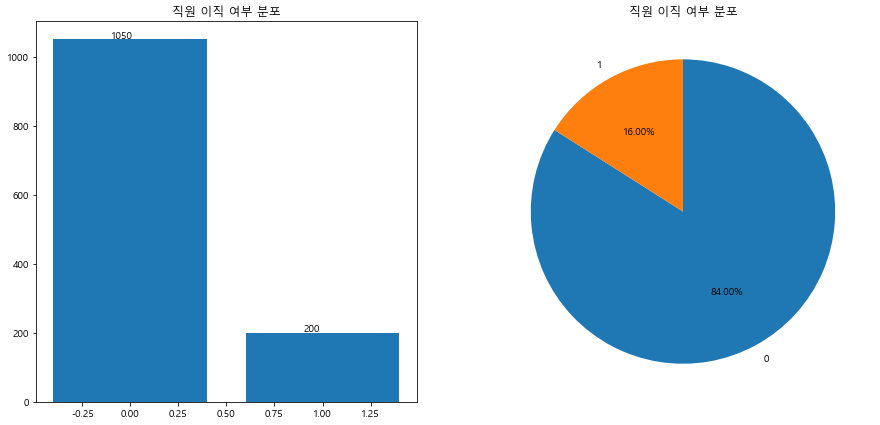

In [6]:
cnt = data[target].value_counts()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.bar(cnt.index, cnt.values)
plt.title('직원 이직 여부 분포')
for i in range(2):
    plt.text(i-.1, cnt.values[i]+5, cnt.values[i])

plt.subplot(1,2,2)
plt.title('직원 이직 여부 분포')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%', startangle=90, counterclock=False)
plt.show()

* 데이터 분포상 직원 잔류비율이 84%로 굉장히 높다.
* 이직한 직원과 잔류한 직원을 비교분석하여 그 차이를 조사하고 이직방지를 위한 전략을 수립해야한다.

### 2) Age(나이)

* 직원 나이
* 숫자형

In [27]:
var = 'Age'

In [28]:
# 결측치 확인
data[var].isna().sum()

0

In [9]:
# 기초통계량 확인
data[var].describe()

count    1250.000000
mean       36.931200
std         9.122162
min        18.000000
25%        30.000000
50%        36.000000
75%        43.000000
max        60.000000
Name: Age, dtype: float64

#### 데이터 분포 및 시각화

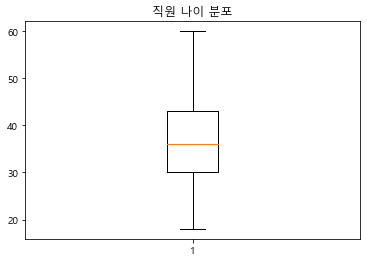

[30. 18.]
[43. 60.]


In [10]:
box = plt.boxplot(data[var])
plt.title('직원 나이 분포')
plt.show()

print(box['whiskers'][0].get_ydata())
print(box['whiskers'][1].get_ydata())

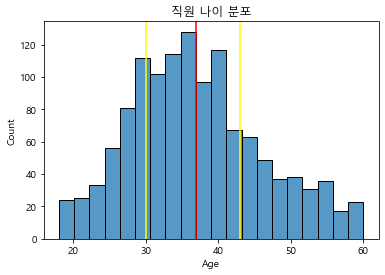

In [15]:
sns.histplot(data[var], bins=20)
plt.title('직원 나이 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

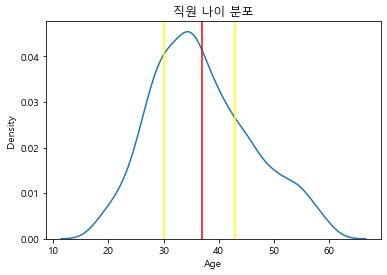

In [16]:
sns.kdeplot(data[var])
plt.title('직원 나이 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

* 30~43에 직원에 50%가량이 분포해 있고 60세 이하의 직원이 75%이다.
* 직원들의 대부분은 30~40대 초반인 것으로 추정되어지며 이 나이대 직원들의 이직여부에 대한 조사가 중요할 것으로 보인다.

### 3) DistanceFromHome(집-직장 거리)

* 집-직장 거리(마일)
* 숫자형

In [29]:
var = 'DistanceFromHome'

In [30]:
# 결측치 확인
data[var].isna().sum()

54

* 변수 특성상 회사 기숙사를 이용하는 직원으로 조사하지 않았을 가능성이 있다.
* 결측치를 0으로 취급하고 0인 직원을 기숙사 이용직원으로 따로 분리하여 분석해볼 필요가 있다.

In [36]:
# 결측치 정리
# data2(0으로 채움)
# data3(결측치 행 제거)
data2 = data.copy()
data2.fillna({var: 0}, inplace=True)
data3 = data.copy()
data3 = data3.loc[data[var].notnull()]

In [129]:
# 기초통계량 확인
data2[var].describe()

count    1250.000000
mean        8.858400
std         8.206499
min         0.000000
25%         2.000000
50%         7.000000
75%        13.000000
max        29.000000
Name: DistanceFromHome, dtype: float64

In [130]:
data3[var].describe()

count    1196.000000
mean        9.258361
std         8.166016
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: DistanceFromHome, dtype: float64

#### 데이터 분포 및 시각화

[2. 0.]
[13. 29.]
[2. 1.]
[14. 29.]


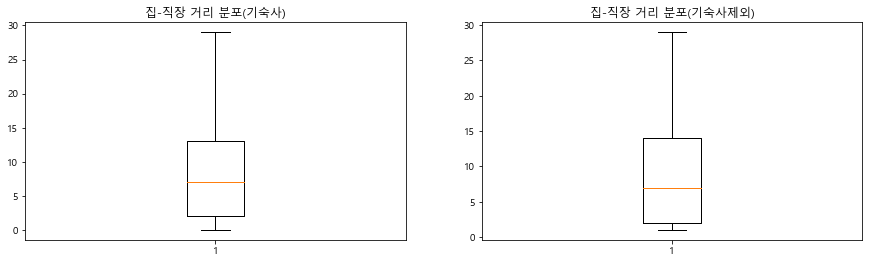

In [52]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
box2 = plt.boxplot(data2[var])
plt.title('집-직장 거리 분포(기숙사)')

print(box2['whiskers'][0].get_ydata())
print(box2['whiskers'][1].get_ydata())

plt.subplot(1,2,2)
box3 = plt.boxplot(data3[var])
plt.title('집-직장 거리 분포(기숙사제외)')

print(box3['whiskers'][0].get_ydata())
print(box3['whiskers'][1].get_ydata())

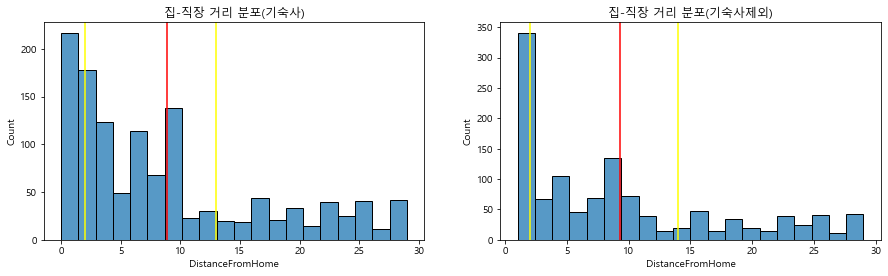

In [53]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.histplot(data2[var], bins=20)
plt.title('집-직장 거리 분포(기숙사)')
plt.axvline(data2[var].mean(), color='r')
plt.axvline(box2['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box2['whiskers'][1].get_ydata()[0], color='yellow')

plt.subplot(1,2,2)
sns.histplot(data3[var], bins=20)
plt.title('집-직장 거리 분포(기숙사제외)')
plt.axvline(data3[var].mean(), color='r')
plt.axvline(box3['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box3['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

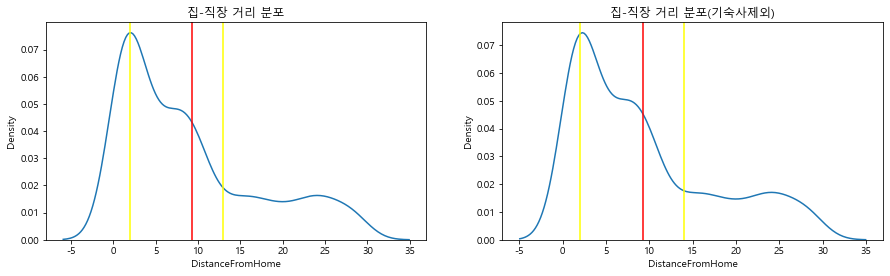

In [54]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.kdeplot(data2[var])
plt.title('집-직장 거리 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box2['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box2['whiskers'][1].get_ydata()[0], color='yellow')

plt.subplot(1,2,2)
sns.kdeplot(data3[var])
plt.title('집-직장 거리 분포(기숙사제외)')
plt.axvline(data3[var].mean(), color='r')
plt.axvline(box3['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box3['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

* 기숙사에 있는 직원을 제외하고 14마일안에 있는 직원이 전체의 75%를 차지한다.
* 7마일 이내에 있는 직원이 전체의 50%를 차지하고 평균치보다 낮은 값이므로 대부분 회사와 가까운 곳에 거주한다.
* 0~2마일 이내에 거주하고 있는 직원의 빈도수가 압도적으로 높기 때문에 분리하여 분석해볼 필요가 있다.

### 4) Gender(성별)

* 성별(남, 여)
* 범주형

In [55]:
var = 'Gender'

In [57]:
# 결측치 확인
data[var].isna().sum()

0

In [58]:
# 기초통계량 확인
data[var].value_counts()

Male      760
Female    490
Name: Gender, dtype: int64

#### 데이터 분포 및 시각화

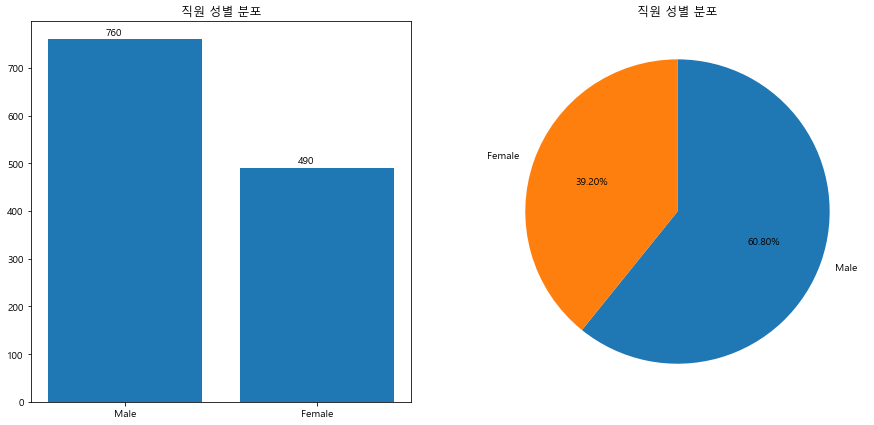

In [59]:
cnt = data[var].value_counts()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.bar(cnt.index, cnt.values)
plt.title('직원 성별 분포')
for i in range(2):
    plt.text(i-.1, cnt.values[i]+10, cnt.values[i])

plt.subplot(1,2,2)
plt.title('직원 성별 분포')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%', startangle=90, counterclock=False)
plt.show()

* 회사 직원 남녀 성비는 대략 6:4이며 남자가 더 많다.
* 신입사원 남녀 성비와 회사직원 남녀성비의 격차가 이직여부와 관련이 있을지 추가 조사해볼 필요가 있다.

### 5) MaritalStatus

* 결혼상태(싱글, 결혼, 이혼)
* 범주형

In [60]:
var = 'MaritalStatus'

In [61]:
# 결측치 확인
data[var].isna().sum()

0

In [62]:
# 기초통계량 분석
data[var].value_counts()

Married     570
Single      404
Divorced    276
Name: MaritalStatus, dtype: int64

#### 데이터 분포 및 시각화

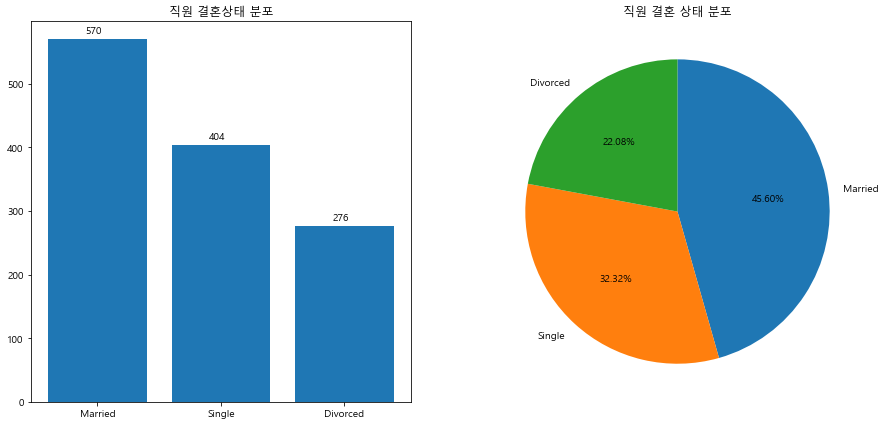

In [63]:
cnt = data[var].value_counts()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.bar(cnt.index, cnt.values)
plt.title('직원 결혼상태 분포')
for i in range(3):
    plt.text(i-.1, cnt.values[i]+10, cnt.values[i])

plt.subplot(1,2,2)
plt.title('직원 결혼 상태 분포')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%', startangle=90, counterclock=False)
plt.show()

* 싱글이고 이혼한 직원이 과반수 이상을 차지하고 있다.

### 6) MonthlyIncome(월급)

* 직원 월급(달러)
* 숫자형

In [64]:
var = 'MonthlyIncome'

In [65]:
# 결측치 확인
data[var].isna().sum()

0

In [66]:
# 기초통계량 확인
data[var].describe()

count     1250.000000
mean      6525.548000
std       4676.979554
min       1009.000000
25%       2932.250000
50%       4988.000000
75%       8437.500000
max      19999.000000
Name: MonthlyIncome, dtype: float64

#### 데이터 분포 및 시각화

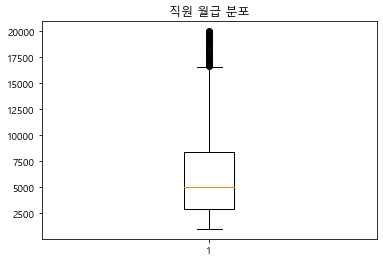

[2932.25 1009.  ]
[ 8437.5 16606. ]


In [67]:
box = plt.boxplot(data[var])
plt.title('직원 월급 분포')
plt.show()

print(box['whiskers'][0].get_ydata())
print(box['whiskers'][1].get_ydata())

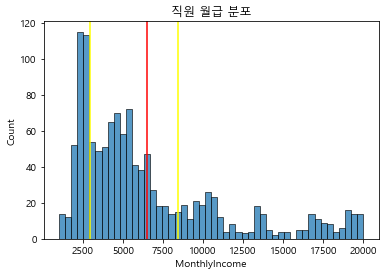

In [69]:
sns.histplot(data[var], bins=50)
plt.title('직원 월급 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

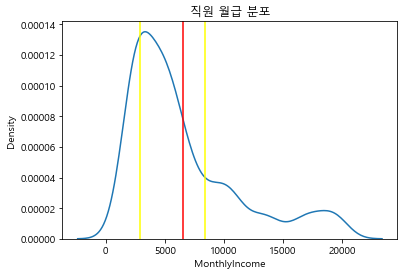

In [70]:
sns.kdeplot(data[var])
plt.title('직원 월급 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

* 16606달러 이상 월급받는 직원은 이상치로 검토해볼 필요가 있다.(임원, 고위직)
* 4988달러 이하에 50%의 직원이 월급을 받고 있는 것과 그래프가 왼쪽으로 치우쳐 있는것으로 볼때 월급 격차가 심하다.

### 7) WorkLifeBalance(워라밸)

* 일-삶 균형도 (1.나쁨, 2.좋음, 3.더 좋음, 4.최고)
* 범주형

In [143]:
var = 'WorkLifeBalance'

In [144]:
# 결측치 확인
data[var].isna().sum()

0

In [73]:
# 기초통계량 확인
data[var].value_counts()

3    747
2    297
4    137
1     69
Name: WorkLifeBalance, dtype: int64

#### 데이터 분포 및 시각화

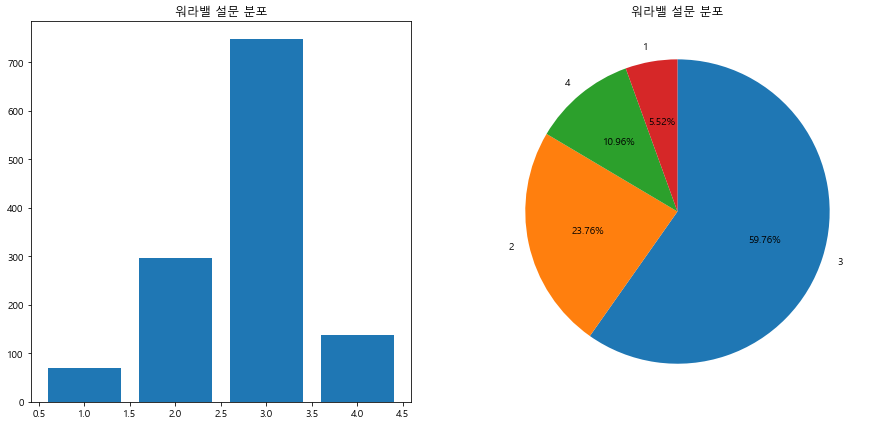

In [145]:
cnt = data[var].value_counts()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.bar(cnt.index, cnt.values)
plt.title('워라밸 설문 분포')

plt.subplot(1,2,2)
plt.title('워라밸 설문 분포')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%', startangle=90, counterclock=False)
plt.show()

* 워라밸이 bad라고 답변한 설문은 전체의 5.52%로 굉장히 적은 편이다.
* better로 대답한 직원이 전체의 60%가량을 차지한다.
* 각 범주별로 나누어 이직여부에 영향을 미치는지 확인해볼 필요가 있다.

### 8) JobSatisfaction(직무 만족도)

* 1 Low, 2 Medium, 3 High, 4 Very High
* 범주형

In [146]:
var = 'JobSatisfaction'

In [147]:
# 결측치 확인
data[var].isna().sum()

0

In [148]:
# 기초통계량 확인
data[var].value_counts()

4    397
3    368
1    250
2    235
Name: JobSatisfaction, dtype: int64

#### 데이터 분포 및 시각화

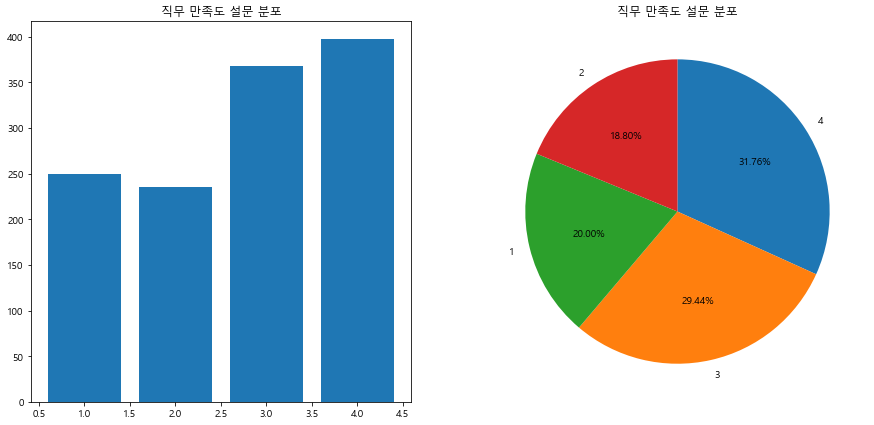

In [150]:
cnt = data[var].value_counts()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.bar(cnt.index, cnt.values)
plt.title('직무 만족도 설문 분포')

plt.subplot(1,2,2)
plt.title('직무 만족도 설문 분포')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%', startangle=90, counterclock=False)
plt.show()

* 직무 만족도가 높다고 대답한 비율이 전체의 60%가량 이며 중간 이상인 비율은 80%가량으로 분포 되어있다.

### 9) OverTime(야근 여부)

* Yes, No
* 범주형

In [151]:
var = 'OverTime'

In [152]:
# 결측치 확인
data[var].isna().sum()

0

In [153]:
# 기초통계량 확인
data[var].value_counts()

No     896
Yes    354
Name: OverTime, dtype: int64

#### 데이터 분포 및 시각화

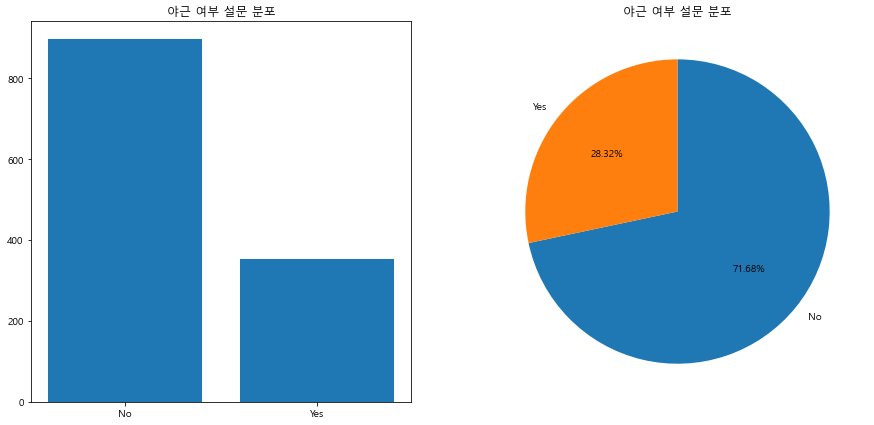

In [155]:
cnt = data[var].value_counts()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.bar(cnt.index, cnt.values)
plt.title('야근 여부 설문 분포')

plt.subplot(1,2,2)
plt.title('야근 여부 설문 분포')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%', startangle=90, counterclock=False)
plt.show()

* 야근을 안한다는 비율이 70%가량으로 높았으며 데이터를 나누어 이직여부에 영향이 있는지 알아볼 필요가 있다.

### 10) NumCompaniesWorked(입사전 근무한 회사 수)

* 0:우리회사가 첫 회사
* 숫자형

In [156]:
var = 'NumCompaniesWorked'

In [157]:
# 결측치 확인
data[var].isna().sum()

21

In [166]:
# 결측치 존재
# 데이터의 75%이하가 4 이하이므로 최빈값으로 대체할 필요가 있다.
data4 = data.copy()
data4.fillna({var:data4[var].mode()[0]}, inplace=True)

In [167]:
# 기초통계량 확인
data4[var].describe()

count    1250.000000
mean        2.650400
std         2.462241
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: NumCompaniesWorked, dtype: float64

#### 데이터 분포 및 시각화

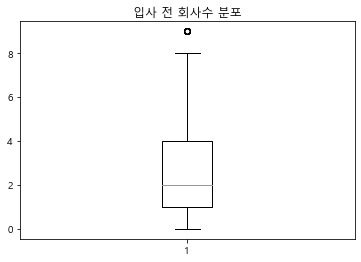

[1. 0.]
[4. 8.]


In [168]:
box = plt.boxplot(data4[var])
plt.title('입사 전 회사수 분포')
plt.show()

print(box['whiskers'][0].get_ydata())
print(box['whiskers'][1].get_ydata())

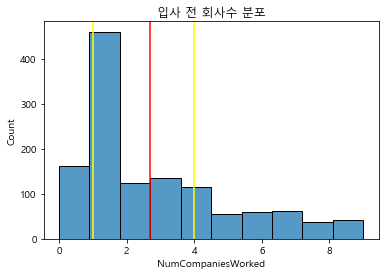

In [169]:
sns.histplot(data4[var], bins=10)
plt.title('입사 전 회사수 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

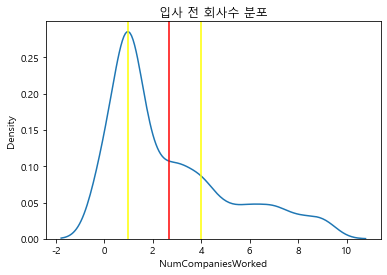

In [170]:
sns.kdeplot(data4[var])
plt.title('입사 전 회사수 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

* 입사 전 회사수가 8개 이상인 직원들은 이상치로 검토해볼 필요가 있다.
* 그래프가 대체로 왼쪽으로 치우쳐 있고 50%에 해당하는 직원은 2개이하의 회사에서 근무하였다.

### 11) PercentSalaryHike(전년대비 급여 인상율%)

* 전년대지 급여 인상율(%)
* 숫자

In [171]:
var = 'PercentSalaryHike'

In [172]:
# 결측치 확인
data[var].isna().sum()

0

In [173]:
# 기초통계량 확인
data[var].describe()

count    1250.000000
mean       15.216000
std         3.625556
min        11.000000
25%        12.000000
50%        14.000000
75%        18.000000
max        25.000000
Name: PercentSalaryHike, dtype: float64

#### 데이터 분포 및 시각화

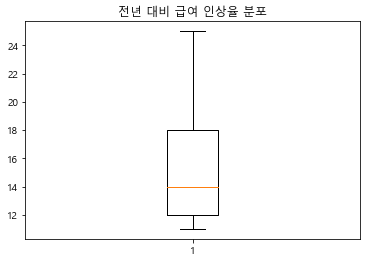

[12. 11.]
[18. 25.]


In [174]:
box = plt.boxplot(data[var])
plt.title('전년 대비 급여 인상율 분포')
plt.show()

print(box['whiskers'][0].get_ydata())
print(box['whiskers'][1].get_ydata())

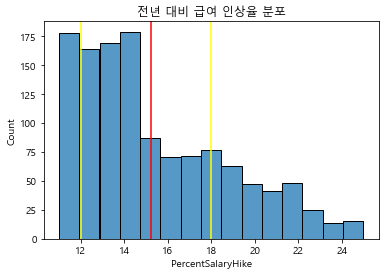

In [180]:
sns.histplot(data[var], bins=15)
plt.title('전년 대비 급여 인상율 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

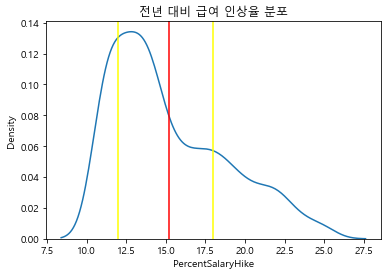

In [181]:
sns.kdeplot(data[var])
plt.title('전년 대비 급여 인상율 분포')
plt.axvline(data[var].mean(), color='r')
plt.axvline(box['whiskers'][0].get_ydata()[0], color='yellow')
plt.axvline(box['whiskers'][1].get_ydata()[0], color='yellow')
plt.show()

* 직원 75%가 급여는 최소 11%에서 18%정도 오르게 되었다.
* 대략 15%정도를 기준으로 급격한 변화가 보이는데 이를 기점으로 분리하여 추가 분석해볼 필요가 있다.

## 3.이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 유의수준 : 5%
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.

### (1) 범주형 Feature --> Target
* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 교차표(pd.crosstab())  
    ② 시각화( Stacked Bar, Mosaic)  
    ③ 가설검정(카이제곱검정)
* 각 feature 별로 관계의 정도를 3가지로 정리해봅시다. 

#### 전체 이직율

In [80]:
total_mean = data[target].mean()
print(total_mean)

0.16


#### 1) Gender --> target

In [103]:
var = 'Gender'

In [82]:
pd.crosstab(data[var], data[target])

Attrition,0,1
Gender,,
Female,421,69
Male,629,131


In [105]:
temp = pd.crosstab(data[var], data[target], normalize='index')
print(temp)

Attrition         0         1
Gender                       
Female     0.859184  0.140816
Male       0.827632  0.172368


#### 시각화

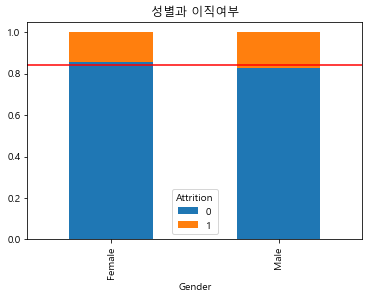

In [106]:
temp.plot.bar(stacked=True)
plt.title('성별과 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

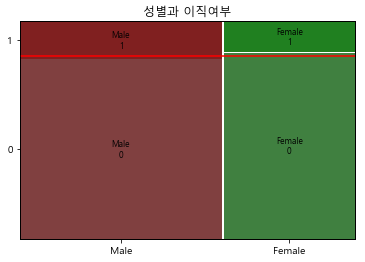

In [107]:
mosaic(data, [var, target])
plt.title('성별과 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

* 그래프상 성별에 따른 이직여부가 거의 평균치와 가깝기 때문에 차이는 없어보인다.

#### 검정

In [108]:
table = pd.crosstab(data[var], data[target])
print(table)
print('-'*100)
result = spst.chi2_contingency(table)
print('카이제곱 통계량 : ', result[0])
print('P-value : ', result[1])
print('기대빈도 : ', result[3])

Attrition    0    1
Gender             
Female     421   69
Male       629  131
----------------------------------------------------------------------------------------------------
카이제곱 통계량 :  1.9782495940105371
P-value :  0.15957492990528155
기대빈도 :  [[411.6  78.4]
 [638.4 121.6]]


* 검정결과 p-value값이 0.05보다 크기때문에 성별에 따른 이직여부에는 차이가 없다.

#### 2) MaritalStatus --> target

In [109]:
var = 'MaritalStatus'

In [110]:
pd.crosstab(data[var], data[target])

Attrition,0,1
MaritalStatus,,
Divorced,253,23
Married,501,69
Single,296,108


In [111]:
temp = pd.crosstab(data[var], data[target], normalize='index')
print(temp)

Attrition             0         1
MaritalStatus                    
Divorced       0.916667  0.083333
Married        0.878947  0.121053
Single         0.732673  0.267327


#### 시각화

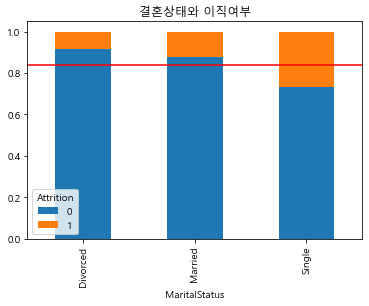

In [112]:
temp.plot.bar(stacked=True)
plt.title('결혼상태와 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

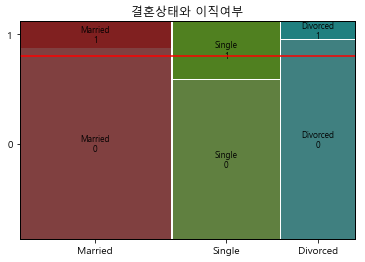

In [113]:
mosaic(data, [var, target])
plt.title('결혼상태와 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

* 그래프상 결혼상태에 따른 이직여부에 유의미한 차이가 있어보인다.

#### 검정

In [114]:
table = pd.crosstab(data[var], data[target])
print(table)
print('-'*100)
result = spst.chi2_contingency(table)
print('카이제곱 통계량 : ', result[0])
print('P-value : ', result[1])
print('기대빈도 : ', result[3])

Attrition        0    1
MaritalStatus          
Divorced       253   23
Married        501   69
Single         296  108
----------------------------------------------------------------------------------------------------
카이제곱 통계량 :  53.12935546374186
P-value :  2.9047385436211595e-12
기대빈도 :  [[231.84  44.16]
 [478.8   91.2 ]
 [339.36  64.64]]


* 검정결과 p-valur값이 충분히 작아 결혼상태에 따른 이직여부에는 차이가 있다.

#### 3) WorkLifeBalance --> target

In [115]:
var = 'WorkLifeBalance'

In [116]:
pd.crosstab(data[var], data[target])

Attrition,0,1
WorkLifeBalance,,
1,49,20
2,251,46
3,639,108
4,111,26


In [117]:
temp = pd.crosstab(data[var], data[target], normalize='index')
print(temp)

Attrition               0         1
WorkLifeBalance                    
1                0.710145  0.289855
2                0.845118  0.154882
3                0.855422  0.144578
4                0.810219  0.189781


#### 시각화

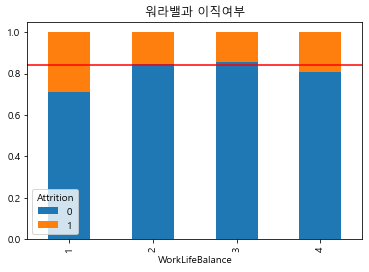

In [118]:
temp.plot.bar(stacked=True)
plt.title('워라밸과 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

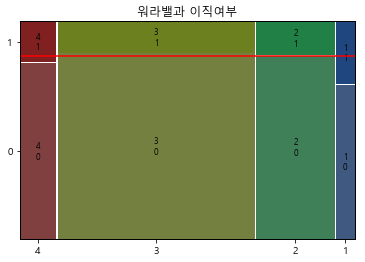

In [119]:
mosaic(data, [var, target])
plt.title('워라밸과 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

* 그래프상 나쁘다고 평가한 사람들의 이직여부가 나머지와 유의미한 차이를 보였으며 좋고 나쁨으로 나누어 분석해볼 필요가 있다.

#### 검정

In [120]:
table = pd.crosstab(data[var], data[target])
print(table)
print('-'*100)
result = spst.chi2_contingency(table)
print('카이제곱 통계량 : ', result[0])
print('P-value : ', result[1])
print('기대빈도 : ', result[3])

Attrition          0    1
WorkLifeBalance          
1                 49   20
2                251   46
3                639  108
4                111   26
----------------------------------------------------------------------------------------------------
카이제곱 통계량 :  10.940810822342664
P-value :  0.012050277390233675
기대빈도 :  [[ 57.96  11.04]
 [249.48  47.52]
 [627.48 119.52]
 [115.08  21.92]]


* 검정결과 p-value값이 0.05보다 작아 워라밸에 따른 이직여부에 차이가 있지만 보수적으로 접근하였을때 0.01보다 높아 차이가 없다고 할 수 있다.
* 좋고 나쁨으로 데이터를 분류하여 추가분석해볼 필요가 있다.

#### 4) JobSatisfaction --> target

In [182]:
var = 'JobSatisfaction'

In [183]:
pd.crosstab(data[var], data[target])

Attrition,0,1
JobSatisfaction,,
1,197,53
2,196,39
3,308,60
4,349,48


In [184]:
temp = pd.crosstab(data[var], data[target], normalize='index')
print(temp)

Attrition               0         1
JobSatisfaction                    
1                0.788000  0.212000
2                0.834043  0.165957
3                0.836957  0.163043
4                0.879093  0.120907


#### 시각화

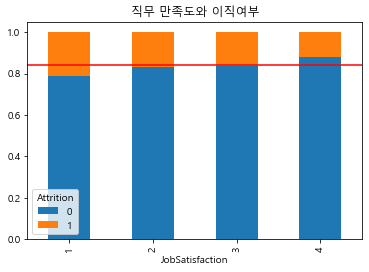

In [187]:
temp.plot.bar(stacked=True)
plt.title('직무 만족도와 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

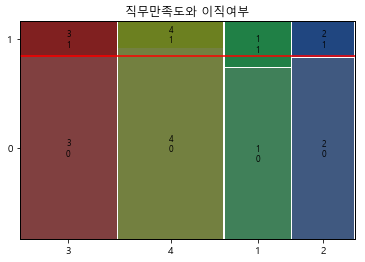

In [188]:
mosaic(data, [var, target])
plt.title('직무만족도와 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

* 그래프상 직무 만족도에 따른 이직여부에는 유의미한 차이가 있다.
* 만족도 나쁨과 매우 좋음과의 차이는 극명하다.

#### 검정

In [189]:
table = pd.crosstab(data[var], data[target])
print(table)
print('-'*100)
result = spst.chi2_contingency(table)
print('카이제곱 통계량 : ', result[0])
print('P-value : ', result[1])
print('기대빈도 : ', result[3])

Attrition          0   1
JobSatisfaction         
1                197  53
2                196  39
3                308  60
4                349  48
----------------------------------------------------------------------------------------------------
카이제곱 통계량 :  9.63151465436614
P-value :  0.021972649369306214
기대빈도 :  [[210.    40.  ]
 [197.4   37.6 ]
 [309.12  58.88]
 [333.48  63.52]]


* p-value값이 0.05보다 작아 직무만족도에 따른 이직여부에는 차이가 있지만 보수적으로 보았을때 0.01보다 크기때문에 차이가 없다고 할 수 있다.
* 데이터를 중간이상과 나쁨으로 분류하여 추가분석해볼 필요가 있다.

#### 5) OverTime --> target

In [190]:
var = 'OverTime'

In [191]:
pd.crosstab(data[var], data[target])

Attrition,0,1
OverTime,,
No,803,93
Yes,247,107


In [192]:
temp = pd.crosstab(data[var], data[target], normalize='index')
print(temp)

Attrition         0         1
OverTime                     
No         0.896205  0.103795
Yes        0.697740  0.302260


#### 시각화

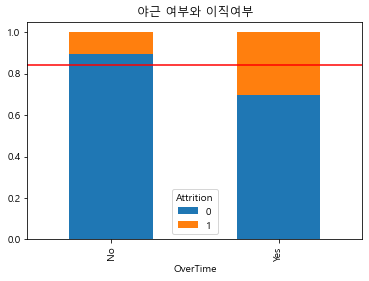

In [193]:
temp.plot.bar(stacked=True)
plt.title('야근 여부와 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

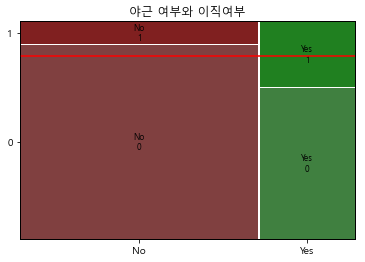

In [194]:
mosaic(data, [var, target])
plt.title('야근 여부와 이직여부')
plt.axhline(1-data[target].mean(), color='r')
plt.show()

* 그래프상 야근여부에 따른 이직여부는 극명한 차이를 보이고 있다.

#### 검정

In [195]:
table = pd.crosstab(data[var], data[target])
print(table)
print('-'*100)
result = spst.chi2_contingency(table)
print('카이제곱 통계량 : ', result[0])
print('P-value : ', result[1])
print('기대빈도 : ', result[3])

Attrition    0    1
OverTime           
No         803   93
Yes        247  107
----------------------------------------------------------------------------------------------------
카이제곱 통계량 :  72.89605419432075
P-value :  1.366611233098835e-17
기대빈도 :  [[752.64 143.36]
 [297.36  56.64]]


* 검정결과 p-value가 충분히 낮아 야근여부에 따른 이직여부에는 차이가 있다

### (2) 숫자형 Feature --> target

* 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 그래프 : histogram, densityplot   
    ② 수치화 : 로지스틱회귀

#### 1) Age --> target

In [121]:
var = 'Age'

#### 시각화

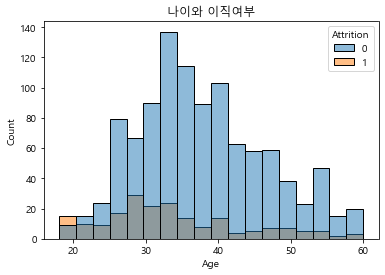

In [124]:
sns.histplot(x=var, hue=target, data=data)
plt.title('나이와 이직여부')
plt.show()

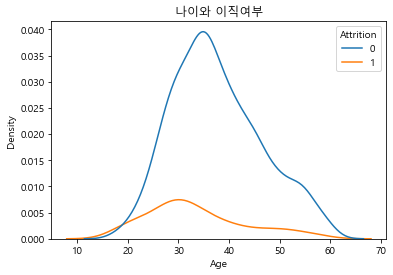

In [125]:
sns.kdeplot(x=var, hue=target, data=data)
plt.title('나이와 이직여부')
plt.show()

* 그래프상 20대 초반 이전을 제외하고는 이직하는 사람이 적다.
* 20대 초반 이전 직원을 따로 분류하여 분석해볼 필요하다.
* 나이에 따라 이직여부 분포에 차이가 있는것으로 보인다.

#### 검정

In [126]:
model = sm.Logit(data[target], data[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.424660
         Iterations 5
Age    4.667821e-100
dtype: float64


* 검정결과 p-value값이 0에 가까워 나이에 따른 이직여부에는 차이가 있다.(약한관계)

#### 2) DistanceFromHome --> target

In [127]:
var = 'DistanceFromHome'

#### 시각화

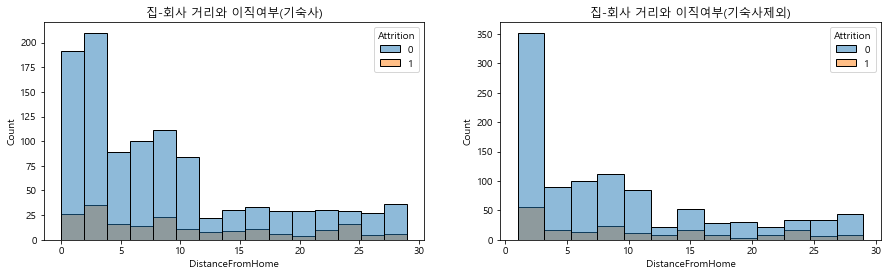

In [133]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.histplot(x=var, hue=target, data=data2)
plt.title('집-회사 거리와 이직여부(기숙사)')

plt.subplot(1,2,2)
sns.histplot(x=var, hue=target, data=data3)
plt.title('집-회사 거리와 이직여부(기숙사제외)')
plt.show()

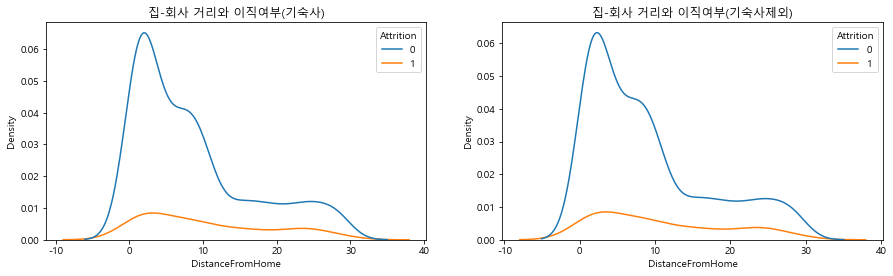

In [134]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.kdeplot(x=var, hue=target, data=data2)
plt.title('집-회사 거리와 이직여부(기숙사)')

plt.subplot(1,2,2)
sns.kdeplot(x=var, hue=target, data=data3)
plt.title('집-회사 거리와 이직여부(기숙사제외)')
plt.show()

* 그래프상 집-회사 거리에 따른 이직여부에는 유의미한 차이가 없어보인다.
* 기숙사로 취급한 데이터와 그렇지 않은 데이터는 유사한 결과를 나타내고 있다.

In [135]:
# 기숙사(결측치를 0으로 취급)
model = sm.Logit(data2[target], data2[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.574165
         Iterations 6
DistanceFromHome    2.694280e-44
dtype: float64


In [136]:
# 기숙사(결측치를 제외)
model = sm.Logit(data3[target], data3[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.568793
         Iterations 6
DistanceFromHome    2.694280e-44
dtype: float64


* 검정결과 집-회사 거리에 따른 이직여부에는 유의미한 차이가 있다고 나오지만 분포 그래프가 비슷하여 그 정도가 약하다고 생각한다.

#### 3) MonthlyIncome --> target

In [137]:
var = 'MonthlyIncome'

#### 시각화

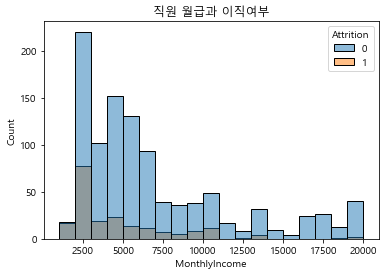

In [138]:
sns.histplot(x=var, hue=target, data=data)
plt.title('직원 월급과 이직여부')
plt.show()

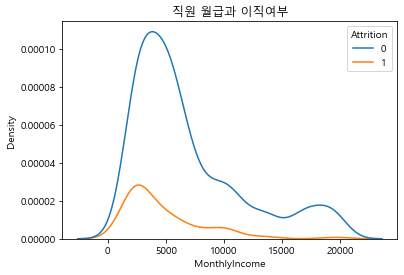

In [140]:
sns.kdeplot(x=var, hue=target, data=data)
plt.title('직원 월급과 이직여부')
plt.show()

* 그래프상 직원월급에 따른 이직여부 분포에 차이가 보인다.
* 월급이 5000달러 이하인 직원들의 이직 분포가 높은편이다.

#### 검정

In [141]:
model = sm.Logit(data[target], data[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.437401
         Iterations 6
MonthlyIncome    1.922717e-71
dtype: float64


* 검정결과 p-value값이 0에 충분히 가까워 직원월급에 따른 이직여부에는 유의미한 차이가 있다.

#### 4) NumCompaniesWorked --> target

In [197]:
var = 'NumCompaniesWorked'

#### 시각화

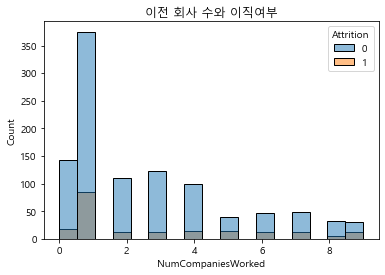

In [205]:
sns.histplot(x=var, hue=target, data=data4)
plt.title('이전 회사 수와 이직여부')
plt.show()

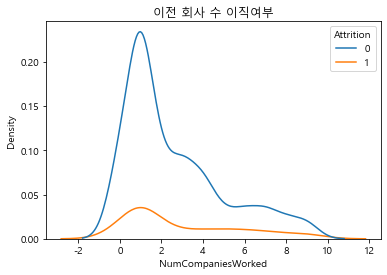

In [206]:
sns.kdeplot(x=var, hue=target, data=data4)
plt.title('이전 회사 수 이직여부')
plt.show()

* 그래프상 이전 회사 수에 따른 이직여부에 차이가 어느정도 있는 것으로 보인다.

#### 검정

In [207]:
model = sm.Logit(data4[target], data4[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.564409
         Iterations 6
NumCompaniesWorked    7.457295e-46
dtype: float64


* 결측치를 최빈값으로 대체하고 검정결과 이전 회사수에 따른 이직여부에 차이가 있다.

#### 5) PercentSalaryHike --> target

In [208]:
var = 'PercentSalaryHike'

#### 시각화

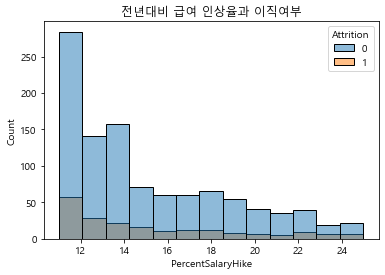

In [209]:
sns.histplot(x=var, hue=target, data=data)
plt.title('전년대비 급여 인상율과 이직여부')
plt.show()

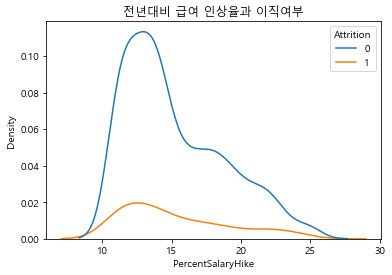

In [210]:
sns.kdeplot(x=var, hue=target, data=data)
plt.title('전년대비 급여 인상율과 이직여부')
plt.show()

* 급여 인상율 변화에 따른 이직여부에는 차이가 많아보이지 않다.

In [211]:
model = sm.Logit(data[target], data[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.450230
         Iterations 5
PercentSalaryHike    3.979995e-95
dtype: float64


* 검정결과 p-value값이 충분히 작아 급여 인상율에 따른 이직여부에는 차이가 있다.

## 4.관계 정리

### 1) 강한관계의 변수

결혼상태, 직원 월급, 야근 여부

### 2) 약한관계의 변수

워라밸, 집-회사 거리, 직무 만족도, 급여 인상율, 이전 회사수, 나이

### 3) 관계 없음

성별

## 5.추가 분석

1) 회사와의 거리 0~2마일 이내에 거주하고 있는 직원의 빈도수가 압도적으로 높기 때문에 분리하여 분석해볼 필요가 있다.

(결측치 기숙사 취급 : data2, 결측치 제거 : data3)

In [212]:
var = 'DistanceFromHome'

In [253]:
A = data2.loc[data2[var] <= 2]
B = data2.loc[data2[var] > 2]
C = data3.loc[data2[var] <= 2]
D = data3.loc[data2[var] > 2]

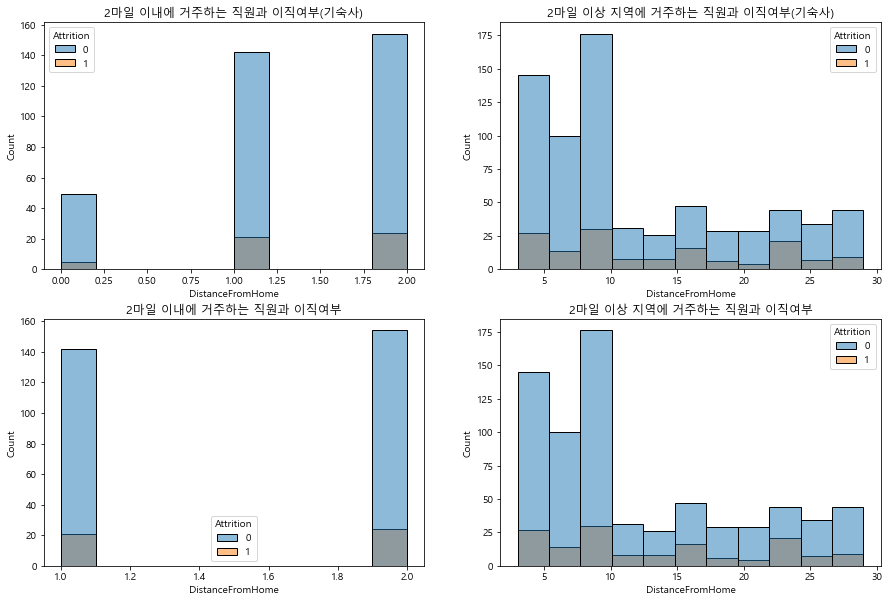

In [248]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.histplot(x=var, hue=target, data=A)
plt.title('2마일 이내에 거주하는 직원과 이직여부(기숙사)')

plt.subplot(2,2,2)
sns.histplot(x=var, hue=target, data=B)
plt.title('2마일 이상 지역에 거주하는 직원과 이직여부(기숙사)')

plt.subplot(2,2,3)
sns.histplot(x=var, hue=target, data=C)
plt.title('2마일 이내에 거주하는 직원과 이직여부')

plt.subplot(2,2,4)
sns.histplot(x=var, hue=target, data=D)
plt.title('2마일 이상 지역에 거주하는 직원과 이직여부')
plt.show()

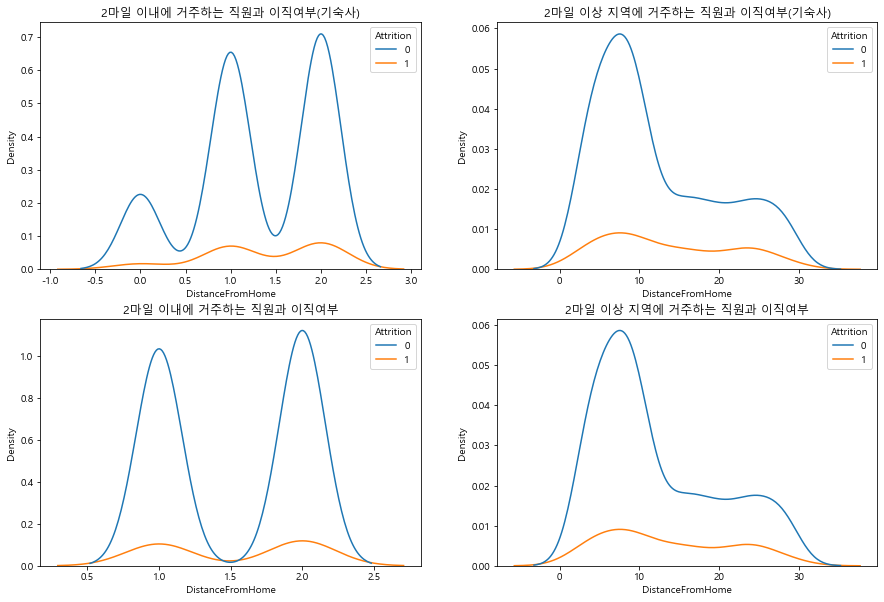

In [254]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.kdeplot(x=var, hue=target, data=A)
plt.title('2마일 이내에 거주하는 직원과 이직여부(기숙사)')

plt.subplot(2,2,2)
sns.kdeplot(x=var, hue=target, data=B)
plt.title('2마일 이상 지역에 거주하는 직원과 이직여부(기숙사)')

plt.subplot(2,2,3)
sns.kdeplot(x=var, hue=target, data=C)
plt.title('2마일 이내에 거주하는 직원과 이직여부')

plt.subplot(2,2,4)
sns.kdeplot(x=var, hue=target, data=D)
plt.title('2마일 이상 지역에 거주하는 직원과 이직여부')
plt.show()

In [255]:
model = sm.Logit(A[target], A[var])
result = model.fit()
print('2마일 이내의 거주 검정 결과 :', result.pvalues)
model = sm.Logit(B[target], B[var])
result = model.fit()
print('2마일 이상 지역의 거주 검정 결과 :', result.pvalues)
model = sm.Logit(C[target], C[var])
result = model.fit()
print('2마일 이상 지역의 거주 검정 결과 :', result.pvalues)
model = sm.Logit(D[target], D[var])
result = model.fit()
print('2마일 이상 지역의 거주 검정 결과 :', result.pvalues)

Optimization terminated successfully.
         Current function value: 0.452115
         Iterations 6
2마일 이내의 거주 검정 결과 : DistanceFromHome    1.059811e-27
dtype: float64
Optimization terminated successfully.
         Current function value: 0.539622
         Iterations 6
2마일 이상 지역의 거주 검정 결과 : DistanceFromHome    4.292987e-41
dtype: float64
Optimization terminated successfully.
         Current function value: 0.413946
         Iterations 6
2마일 이상 지역의 거주 검정 결과 : DistanceFromHome    1.059811e-27
dtype: float64
Optimization terminated successfully.
         Current function value: 0.539622
         Iterations 6
2마일 이상 지역의 거주 검정 결과 : DistanceFromHome    4.292987e-41
dtype: float64


* 기숙사에 거주한다고 가정했을 경우 기숙사의 거주하는 인원은 이직율이 낮다.
* 10마일과 1, 2마일 거주하는 사람들의 이직 빈도가 비슷하기 때문에 10마일을 기준으로 한번 더 나누어 분석해 볼 필요가 있다.
* 검정결과 거리에 따라 이탈여부에는 차이가 있다.

2) 10마일 기준

In [257]:
A = data2.loc[data2[var] <= 10]
B = data2.loc[data2[var] > 10]
C = data3.loc[data2[var] <= 10]
D = data3.loc[data2[var] > 10]

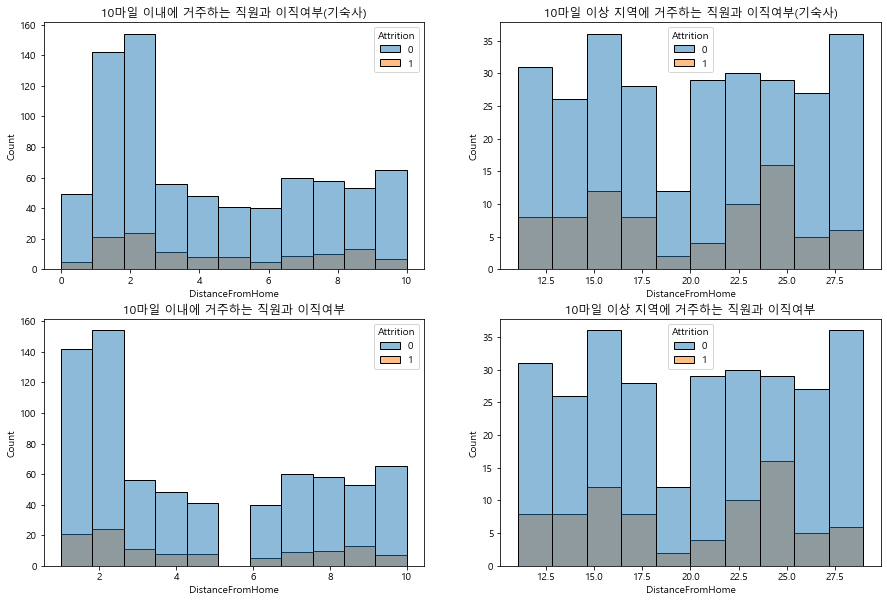

In [258]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.histplot(x=var, hue=target, data=A)
plt.title('10마일 이내에 거주하는 직원과 이직여부(기숙사)')

plt.subplot(2,2,2)
sns.histplot(x=var, hue=target, data=B)
plt.title('10마일 이상 지역에 거주하는 직원과 이직여부(기숙사)')

plt.subplot(2,2,3)
sns.histplot(x=var, hue=target, data=C)
plt.title('10마일 이내에 거주하는 직원과 이직여부')

plt.subplot(2,2,4)
sns.histplot(x=var, hue=target, data=D)
plt.title('10마일 이상 지역에 거주하는 직원과 이직여부')
plt.show()

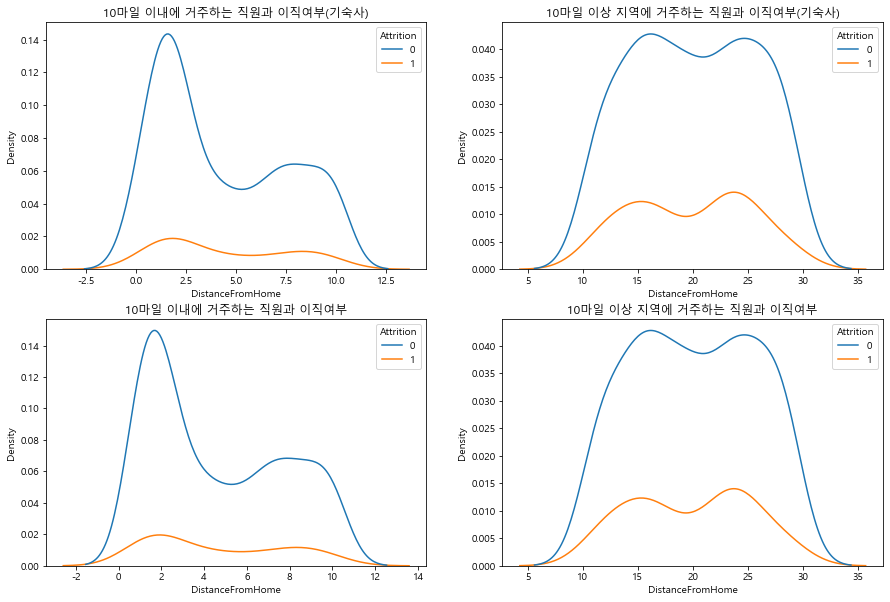

In [259]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.kdeplot(x=var, hue=target, data=A)
plt.title('10마일 이내에 거주하는 직원과 이직여부(기숙사)')

plt.subplot(2,2,2)
sns.kdeplot(x=var, hue=target, data=B)
plt.title('10마일 이상 지역에 거주하는 직원과 이직여부(기숙사)')

plt.subplot(2,2,3)
sns.kdeplot(x=var, hue=target, data=C)
plt.title('10마일 이내에 거주하는 직원과 이직여부')

plt.subplot(2,2,4)
sns.kdeplot(x=var, hue=target, data=D)
plt.title('10마일 이상 지역에 거주하는 직원과 이직여부')
plt.show()

In [260]:
model = sm.Logit(A[target], A[var])
result = model.fit()
print('2마일 이내의 거주 검정 결과 :', result.pvalues)
model = sm.Logit(B[target], B[var])
result = model.fit()
print('2마일 이상 지역의 거주 검정 결과 :', result.pvalues)
model = sm.Logit(C[target], C[var])
result = model.fit()
print('2마일 이상 지역의 거주 검정 결과 :', result.pvalues)
model = sm.Logit(D[target], D[var])
result = model.fit()
print('2마일 이상 지역의 거주 검정 결과 :', result.pvalues)

Optimization terminated successfully.
         Current function value: 0.498026
         Iterations 6
2마일 이내의 거주 검정 결과 : DistanceFromHome    6.160259e-45
dtype: float64
Optimization terminated successfully.
         Current function value: 0.531410
         Iterations 5
2마일 이상 지역의 거주 검정 결과 : DistanceFromHome    3.982763e-22
dtype: float64
Optimization terminated successfully.
         Current function value: 0.485377
         Iterations 6
2마일 이상 지역의 거주 검정 결과 : DistanceFromHome    6.160259e-45
dtype: float64
Optimization terminated successfully.
         Current function value: 0.531410
         Iterations 5
2마일 이상 지역의 거주 검정 결과 : DistanceFromHome    3.982763e-22
dtype: float64


* 검정결과 회사와의 거리에 따른 이직 여부에는 차이가 있지만 3가지 그룹으로 나뉜다고 볼 수 있다.(0부터 2, 3에서 10, 10이상)

## 각 변수들 간의 상관관계 분석

In [228]:
data.corr()

,Attrition,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance
Attrition,1.000000,-0.170209,0.081973,-0.084364,-0.166861,0.054454,0.005901,-0.053857,-0.185029,-0.037603
Age,-0.170209,1.000000,-0.010917,-0.016142,0.489822,0.292489,-0.007442,0.050924,0.678051,-0.002516
DistanceFromHome,0.081973,-0.010917,1.000000,-0.021623,-0.012803,-0.039472,0.052348,0.015040,0.002606,-0.023166
JobSatisfaction,-0.084364,-0.016142,-0.021623,1.000000,-0.023258,-0.047899,0.029032,-0.000973,-0.038403,-0.015702
MonthlyIncome,-0.166861,0.489822,-0.012803,-0.023258,1.000000,0.141670,-0.027852,0.021896,0.766927,0.048163
NumCompaniesWorked,0.054454,0.292489,-0.039472,-0.047899,0.141670,1.000000,0.001516,0.035915,0.228027,0.000365
PercentSalaryHike,0.005901,-0.007442,0.052348,0.029032,-0.027852,0.001516,1.000000,-0.031585,-0.026669,-0.007605
RelationshipSatisfaction,-0.053857,0.050924,0.015040,-0.000973,0.021896,0.035915,-0.031585,1.000000,0.024620,0.013376
TotalWorkingYears,-0.185029,0.678051,0.002606,-0.038403,0.766927,0.228027,-0.026669,0.024620,1.000000,0.020399
WorkLifeBalance,-0.037603,-0.002516,-0.023166,-0.015702,0.048163,0.000365,-0.007605,0.013376,0.020399,1.000000


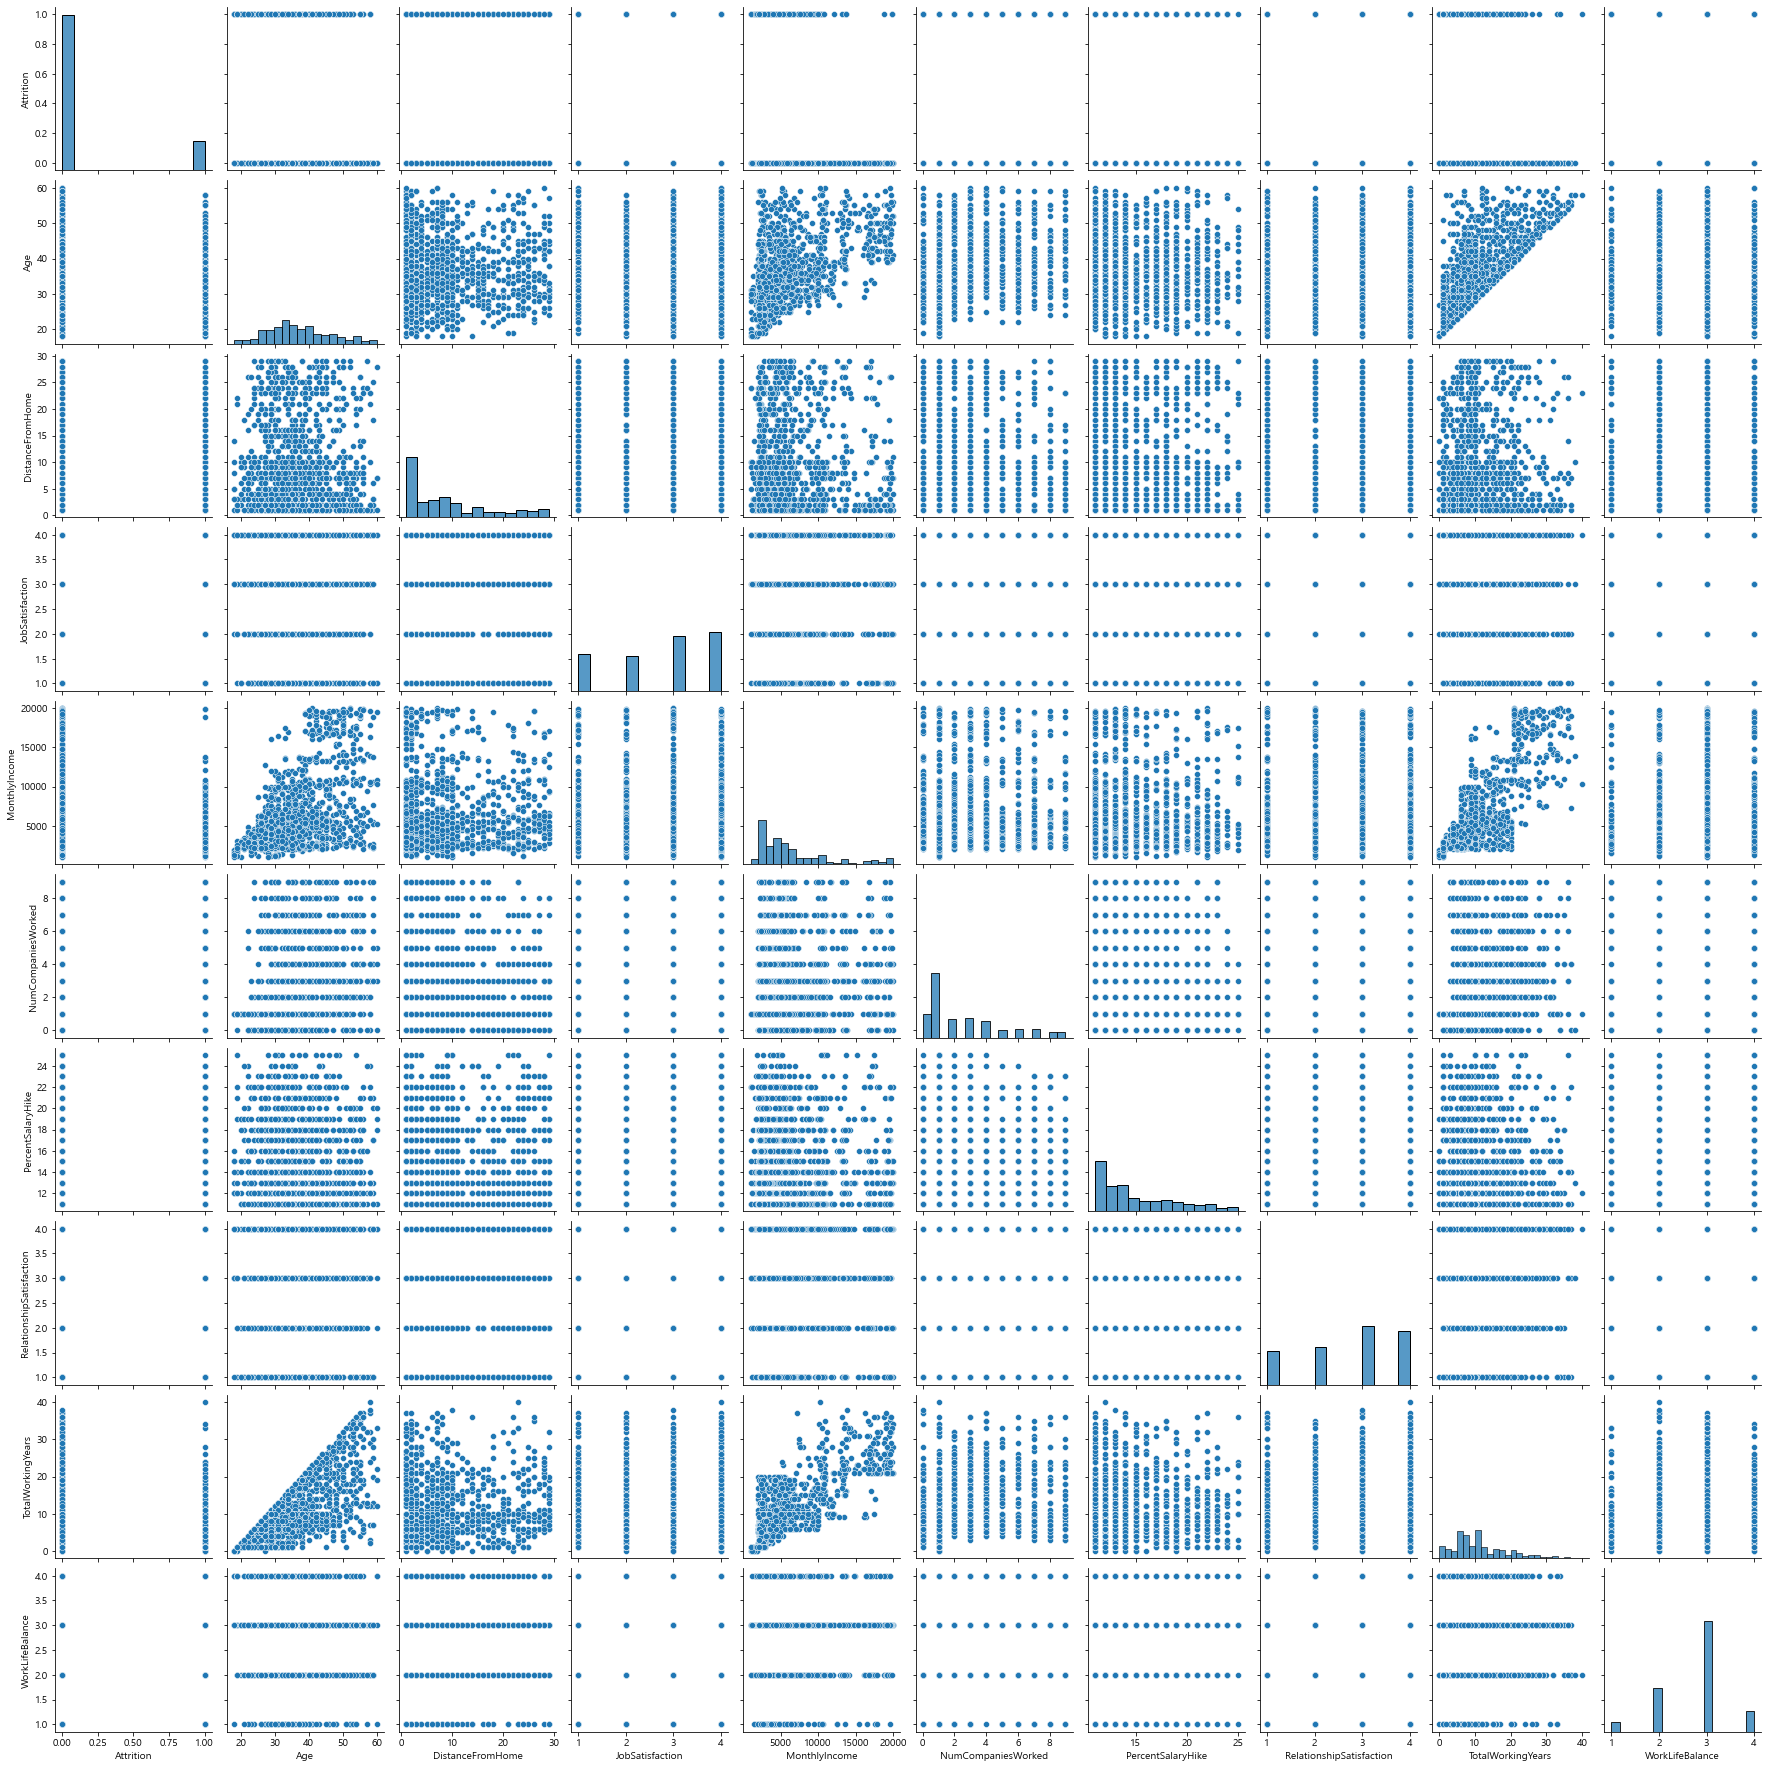

In [261]:
sns.pairplot(data)
plt.show()

* 일한 년수와 나이, 월급은 서로 강한 상관관계를 가지고 있다.
* 이전회사수와 나이는 상관관계가 강하며 월급과도 어느정도 관계가 있다.